In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

# from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# nltk.download('stopwords')


In [40]:
df_8label = pd.read_csv("SC_Vuln_8label.csv", index_col=0)
print(df_8label.head())
print(df_8label.isnull().sum()) #no missing values

    filename                                               code  \
0  33790.sol  pragma solidity ^0.4.4;\r\n\r\ncontract Token ...   
1  31454.sol  pragma solidity ^0.4.4;\r\n\r\ncontract Token ...   
2  40744.sol  contract SendBalance {\r\n mapping (address =>...   
3  39290.sol  /**\r\n * Originally from https://github.com/C...   
4  39358.sol  pragma solidity ^0.4.4;\r\n\r\nlibrary ArrayLi...   

                        label  label_encoded  
0  ./Dataset/reentrancy (RE)/              5  
1  ./Dataset/reentrancy (RE)/              5  
2  ./Dataset/reentrancy (RE)/              5  
3  ./Dataset/reentrancy (RE)/              5  
4  ./Dataset/reentrancy (RE)/              5  
filename         0
code             0
label            0
label_encoded    0
dtype: int64


In [41]:
import numpy as np
from datasets import load_dataset

ds = load_dataset("mwritescode/slither-audited-smart-contracts", "all-multilabel", trust_remote_code=True)

df = ds['train'].to_pandas()
df['slither'] = df['slither'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

safe_contracts = df[df['slither'].apply(lambda x: x == [38])]
safe_contracts_final = pd.DataFrame({
    'filename': safe_contracts['address'],
    'code': safe_contracts['source_code'],
    'label': "No Vulnerability",
    'label_encoded': 8, 
})
safe_contracts_limited = safe_contracts_final.head(3000)
safe_contracts_limited.to_csv("safe_contracts.csv", index=False)


In [42]:
print(safe_contracts_limited .head())
print(safe_contracts_limited ['label'].value_counts())

                                     filename  \
2  0x010c5322d78c88ca18282b0a072a8913648b3038   
3  0x0114622386c1a00686e594c70682d7aa0f8afa29   
7  0x0258f474786ddfd37abce6df6bbb1dd5dfc4434a   
8  0x0263e1dcfcaaad8fd4e840fe4b22854485a561f0   
9  0x0319a976c8dea5d31d1cf36eaffd8bec14957179   

                                                code             label  \
2  pragma solidity 0.6.5;\npragma experimental AB...  No Vulnerability   
3  pragma solidity 0.6.6;\n\nlibrary Address {\n\...  No Vulnerability   
7  pragma solidity 0.5.10;\n\ncontract Context {\...  No Vulnerability   
8  pragma solidity 0.6.6;\n\nlibrary Address {\n\...  No Vulnerability   
9  pragma solidity 0.6.5;\npragma experimental AB...  No Vulnerability   

   label_encoded  
2              8  
3              8  
7              8  
8              8  
9              8  
label
No Vulnerability    3000
Name: count, dtype: int64


In [43]:
safe_contracts_code = safe_contracts_limited.drop_duplicates(subset='filename', keep='first')

#combine the two datasets
combined_data = pd.concat([df_8label, safe_contracts_code], ignore_index=True)
# combined_data.to_csv("combined_dataset.csv", index=False)

# combined_data.to_csv("combined_dataset.csv", index=False)

In [44]:
# Define vulnerability labels
import json
labels = [
    "No Vulnerability",
    "./Dataset/block number dependency (BN)",
    "./Dataset/dangerous delegatecall (DE)/",
    "./Dataset/ether frozen (EF)",
    "./Dataset/ether strict equality (SE)",
    "./Dataset/integer overflow (OF)/",
    "./Dataset/reentrancy (RE)/",
    "./Dataset/timestamp dependency (TP)/",
    "./Dataset/unchecked external call (UC)"
]

# Create a mapping dictionary for easy retrieval
vulnerability_map = {}  # First index is for no vulnerability
for i, label in enumerate(labels, start=0):
    vulnerability_map[i] = label
    
# Save mapping as a JSON file
with open("vulnerability_map.json", "w") as f:
    json.dump(vulnerability_map, f, indent=4)

# Create 8 vulnerability columns with default 0
for label in labels:
    combined_data[label] = 0

# Add a new column for vulnerability status
combined_data["vulnerability_exists"] = 0

# Update labels based on the 'label' column
for index, row in combined_data.iterrows():
    if row["label"] in labels:
        combined_data.at[index, row["label"]] = 1  # Mark as vulnerable
        if(row["label"] == "No Vulnerability"):
            combined_data.at[index, "vulnerability_exists"] = 0  # Mark vulnerability status as 0
        else:
            combined_data.at[index, "vulnerability_exists"] = 1  # Mark vulnerability status as 1


# Drop old 'label' and 'label_encoded' columns
combined_data = combined_data.drop(columns=["label", "label_encoded"])

# Aggregate data by filename and code, ensuring a single row per file
combined_data = combined_data.groupby(["filename", "code"], as_index=False).max()

# Convert vulnerability columns into a list representation
combined_data["vulnerability_list"] = combined_data[labels].apply(lambda x: x.tolist(), axis=1)

# Drop the individual vulnerability columns
combined_data = combined_data.drop(columns=labels)

# drop duplicates rows based on code and vulnerability_list columns
combined_data = combined_data.drop_duplicates(subset=['code'], keep='first')

# Save the processed dataset
combined_data.to_csv("combined_dataset_processed.csv", index=False)


print("Saved processed dataset as 'combined_dataset_processed.csv'.")
print("Saved vulnerability mapping as 'vulnerability_map.json'.")


Saved processed dataset as 'combined_dataset_processed.csv'.
Saved vulnerability mapping as 'vulnerability_map.json'.


In [45]:
# Example of Retrieve Vulnerability Names

# Load the mapping
with open("vulnerability_map.json", "r") as f:
    vulnerability_map = json.load(f)

print(vulnerability_map["0"])
print(vulnerability_map["2"])  
print(vulnerability_map["3"])

# or

# Convert keys to integers (optional, but recommended)
vulnerability_map = {int(k): v for k, v in vulnerability_map.items()}

print(vulnerability_map[1])
print(vulnerability_map[5])  
print(vulnerability_map[6])

No Vulnerability
./Dataset/dangerous delegatecall (DE)/
./Dataset/ether frozen (EF)
./Dataset/block number dependency (BN)
./Dataset/integer overflow (OF)/
./Dataset/reentrancy (RE)/


 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5371 entries, 0 to 5370
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   filename              5371 non-null   object
 1   code                  5371 non-null   object
 2   vulnerability_exists  5371 non-null   int64 
 3   vulnerability_list    5371 non-null   object
dtypes: int64(1), object(3)
memory usage: 168.0+ KB
None

 Missing Value Statistics:
 filename                0
code                    0
vulnerability_exists    0
vulnerability_list      0
dtype: int64

 Total Rows in Dataset: 5371

 Unique Filenames: 5367

 Vulnerability Label Distribution:
                             Vulnerability  Count
0                        No Vulnerability   2873
1  ./Dataset/block number dependency (BN)    370
2  ./Dataset/dangerous delegatecall (DE)/     77
3             ./Dataset/ether frozen (EF)     77
4    ./Dataset/ether strict equalit

C:\Users\FLZ\AppData\Local\Temp\ipykernel_35768\3036644127.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Vulnerability", y="Count", data=vulnerability_eda, palette="viridis")


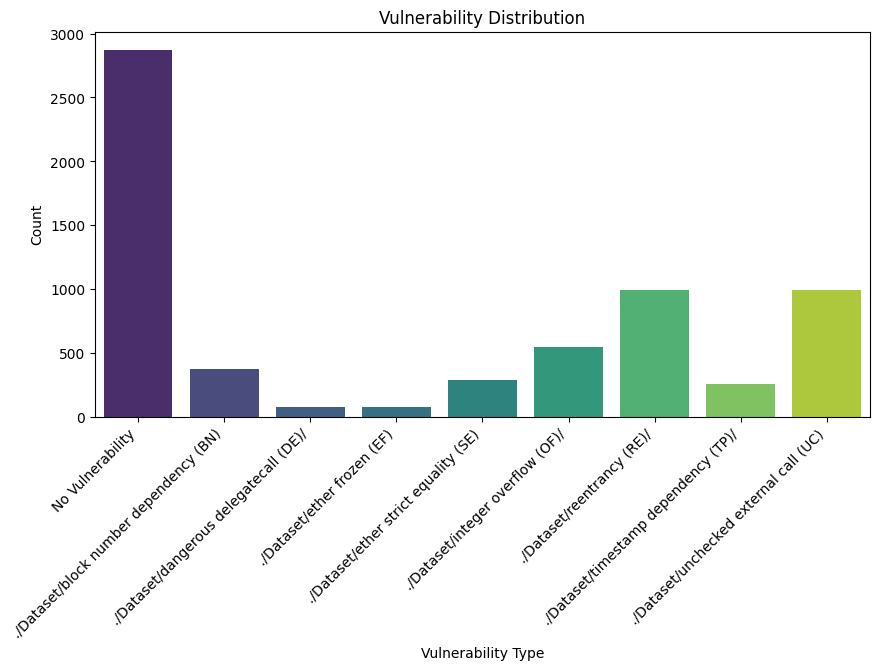

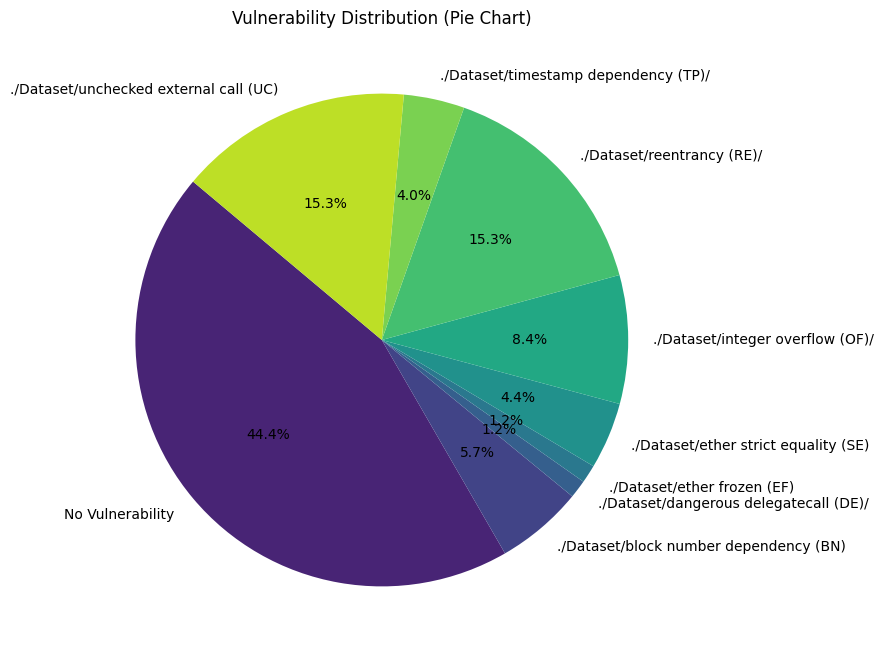

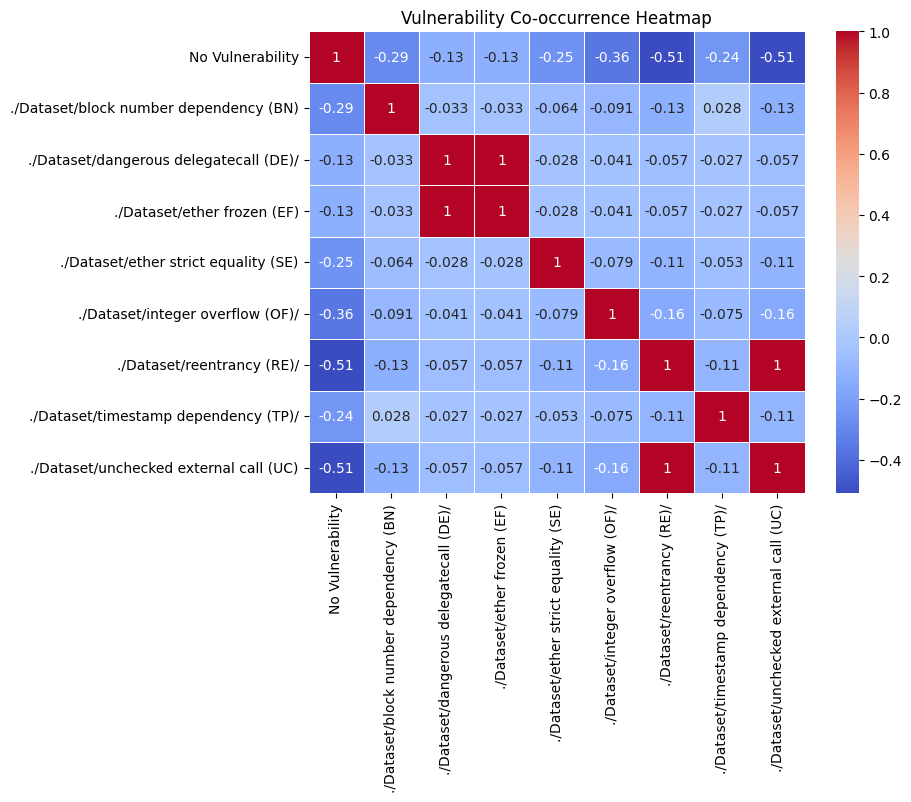

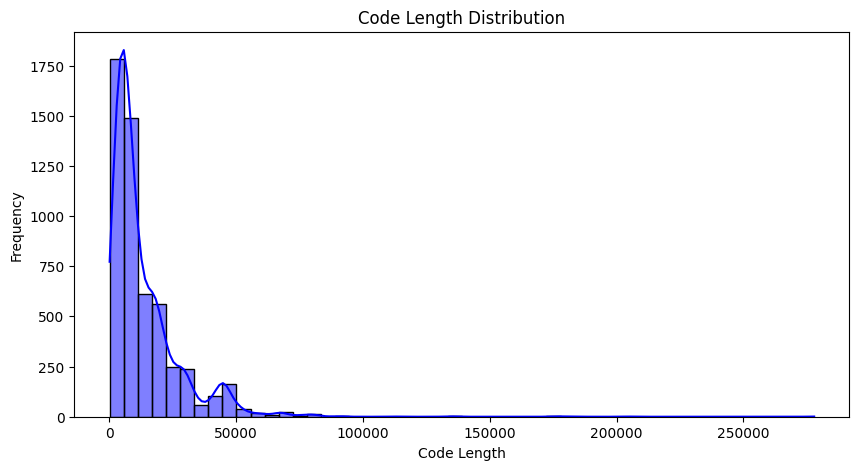

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns


# Load dataset
eda = pd.read_csv("combined_dataset_processed.csv")


# Load vulnerability map
with open("vulnerability_map.json", "r") as f:
    vulnerability_map = json.load(f)
    vulnerability_map = {int(k): v for k, v in vulnerability_map.items()}  # Convert keys to integers


### === 1 Basic Dataset Information === ###
print(" Dataset Overview:")
print(eda.info())   # Data types & missing values
print("\n Missing Value Statistics:\n", eda.isnull().sum())
print("\n Total Rows in Dataset:", eda.shape[0])


# Check if filenames are unique
print("\n Unique Filenames:", eda["filename"].nunique())


# Convert string representation of list to actual list
eda["vulnerability_list"] = eda["vulnerability_list"].apply(lambda x: eval(x) if isinstance(x, str) else x)


# Count vulnerabilities
vulnerability_counts = [0] * len(vulnerability_map)
for row in eda["vulnerability_list"]:
    for i, presence in enumerate(row):
        vulnerability_counts[i] += presence


# Convert counts to DataFrame for visualization
vulnerability_eda = pd.DataFrame(
    {"Vulnerability": [vulnerability_map[i] for i in range(len(vulnerability_map))], "Count": vulnerability_counts}
)


print("\n Vulnerability Label Distribution:\n", vulnerability_eda)


### === 2 Label Distribution Visualization === ###
plt.figure(figsize=(10,5))
sns.barplot(x="Vulnerability", y="Count", data=vulnerability_eda, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Vulnerability Type")
plt.ylabel("Count")
plt.title("Vulnerability Distribution")
plt.show()


### === 3 Pie Chart for Vulnerability Distribution === ###
plt.figure(figsize=(8, 8))
plt.pie(
    vulnerability_eda["Count"],
    labels=vulnerability_eda["Vulnerability"],
    autopct="%1.1f%%",
    colors=sns.color_palette("viridis", len(vulnerability_eda)),
    startangle=140
)
plt.title("Vulnerability Distribution (Pie Chart)")
plt.show()


### === 4 Co-occurrence Analysis (Heatmap) === ###
# Convert list format back into a DataFrame with separate columns for each vulnerability
vulnerability_matrix = pd.DataFrame(eda["vulnerability_list"].to_list(), columns=vulnerability_map.values())


plt.figure(figsize=(8,6))
sns.heatmap(vulnerability_matrix.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Vulnerability Co-occurrence Heatmap")
plt.show()


### === 5 Code Length Distribution === ###
# Compute code length
eda["code_length"] = eda["code"].apply(lambda x: len(str(x)))


# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(eda["code_length"], bins=50, kde=True, color="blue")
plt.xlabel("Code Length")
plt.ylabel("Frequency")
plt.title("Code Length Distribution")
plt.show()

In [47]:
# add ‘pragma solidity' to the file
# print(df['code'][0])
import re

df_solidity=pd.read_csv("combined_dataset_processed.csv")

def extract_pragma_solidity(code):
    if isinstance(code, str):
        match = re.search(r"pragma solidity [\^~]?\d+\.\d+\.\d+;", code)
        if match:
            return match.group(0)  # Return the matched pragma statement
    return None  # Return None if no match is found

# Apply the function to the 'code' column and create a new column
df_solidity['pragma_solidity'] = df_solidity['code'].apply(extract_pragma_solidity)

# Save the updated DataFrame back to the CSV file
df_solidity.to_csv("combined_dataset_processed.csv", index=False)
print(df_solidity.head())

                                     filename  \
0                                       0.sol   
1  0x00000000000045166c45af0fc6e4cf31d9e14b9a   
2  0x000000000000cd17345801aa8147b8D3950260FF   
3  0x000000000000d0151e748d25b766e77efe2a6c83   
4  0x0000000000027f6d87be8ade118d9ee56767d993   

                                                code  vulnerability_exists  \
0  pragma solidity ^0.4.24;\r\ncontract BREBuy {\...                     1   
1  /**\n *Submitted for verification at Etherscan...                     0   
2  /**\n *Submitted for verification at Etherscan...                     0   
3  /**\n *Submitted for verification at Etherscan...                     0   
4  pragma solidity ^0.4.23;\n\n// File: openzeppe...                     0   

            vulnerability_list           pragma_solidity  
0  [0, 1, 0, 0, 0, 0, 0, 0, 0]  pragma solidity ^0.4.24;  
1  [1, 0, 0, 0, 0, 0, 0, 0, 0]  pragma solidity ^0.5.16;  
2  [1, 0, 0, 0, 0, 0, 0, 0, 0]    pragma solidity 0.8.0;  


In [48]:

df_cleancode = pd.read_csv("combined_dataset_processed.csv")

def clean_code(code):
    # Remove comments (single-line and multi-line)
    if not isinstance(code, str):
        return code
    code = re.sub(r'\/\/.*', '', code)
    code = re.sub(r'\/\*[\s\S]*?\*\/', '', code)
    code = re.sub(r'import\s+["\'][^"\']+["\'];', '', code)
    code = re.sub(r'pragma solidity\s+[^\s;]+;', '', code)

    string_literals = re.findall(r'"[^"]*"|\'[^\']*\'', code)
    # string_map = {s: f'__STRING{idx}__' for idx, s in enumerate(string_literals)}
    # for string, placeholder in string_map.items():
    #     code = code.replace(string, placeholder)

    code = re.sub(r'\s+', ' ', code).strip()
    return code

df_cleancode['code'] = df_cleancode['code'].apply(clean_code)
# df_subset['code'] = df_subset['code'].apply(clean_code)
df_cleancode.to_csv("combined_dataset_cleaned.csv", index=False)
print(df_cleancode.head())   


                                     filename  \
0                                       0.sol   
1  0x00000000000045166c45af0fc6e4cf31d9e14b9a   
2  0x000000000000cd17345801aa8147b8D3950260FF   
3  0x000000000000d0151e748d25b766e77efe2a6c83   
4  0x0000000000027f6d87be8ade118d9ee56767d993   

                                                code  vulnerability_exists  \
0  contract BREBuy { struct ContractParam { uint3...                     1   
1  interface IERC20 { function totalSupply() exte...                     0   
2  interface IPoster { event NewPost(address inde...                     0   
3  contract Context { constructor () internal { }...                     0   
4  contract Ownable { address public owner; event...                     0   

            vulnerability_list           pragma_solidity  
0  [0, 1, 0, 0, 0, 0, 0, 0, 0]  pragma solidity ^0.4.24;  
1  [1, 0, 0, 0, 0, 0, 0, 0, 0]  pragma solidity ^0.5.16;  
2  [1, 0, 0, 0, 0, 0, 0, 0, 0]    pragma solidity 0.8.0;  


 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5371 entries, 0 to 5370
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   filename              5371 non-null   object
 1   code                  5371 non-null   object
 2   vulnerability_exists  5371 non-null   int64 
 3   vulnerability_list    5371 non-null   object
 4   pragma_solidity       5053 non-null   object
dtypes: int64(1), object(4)
memory usage: 209.9+ KB
None

 Missing Value Statistics:
 filename                  0
code                      0
vulnerability_exists      0
vulnerability_list        0
pragma_solidity         318
dtype: int64

 Total Rows in Dataset: 5371

 Unique Filenames: 5367

 Vulnerability Label Distribution:
                             Vulnerability  Count
0                        No Vulnerability   2873
1  ./Dataset/block number dependency (BN)    370
2  ./Dataset/dangerous delegatecall (DE)/     7

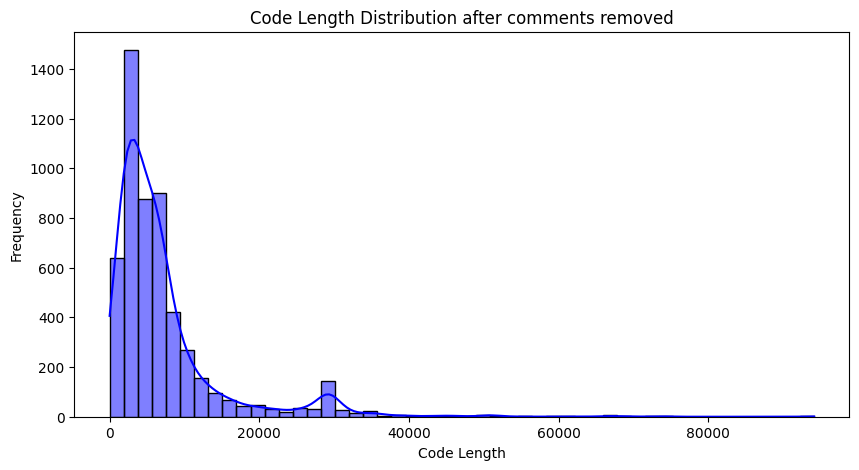

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
eda = df_cleancode

# Load vulnerability map
with open("vulnerability_map.json", "r") as f:
    vulnerability_map = json.load(f)
    vulnerability_map = {int(k): v for k, v in vulnerability_map.items()}  # Convert keys to integers

### === 1 Basic Dataset Information === ###
print(" Dataset Overview:")
print(eda.info())   # Data types & missing values
print("\n Missing Value Statistics:\n", eda.isnull().sum())
print("\n Total Rows in Dataset:", eda.shape[0])

# Check if filenames are unique
print("\n Unique Filenames:", eda["filename"].nunique())

# Convert string representation of list to actual list
eda["vulnerability_list"] = eda["vulnerability_list"].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Count vulnerabilities
vulnerability_counts = [0] * len(vulnerability_map)
for row in eda["vulnerability_list"]:
    for i, presence in enumerate(row):
        vulnerability_counts[i] += presence

# Convert counts to DataFrame for visualization
vulnerability_eda = pd.DataFrame(
    {"Vulnerability": [vulnerability_map[i] for i in range(len(vulnerability_map))], "Count": vulnerability_counts}
)

print("\n Vulnerability Label Distribution:\n", vulnerability_eda)

### === 5 Code Length Distribution === ###
# Compute code length
eda["code_length"] = eda["code"].apply(lambda x: len(str(x)))

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(eda["code_length"], bins=50, kde=True, color="blue")
plt.xlabel("Code Length")
plt.ylabel("Frequency")
plt.title("Code Length Distribution after comments removed")
plt.show()

In [50]:
# opcode and bycode

# import re
# import solcx
# from solcx import compile_source, install_solc, set_solc_version, get_solc_version

# # df_code = pd.read_csv("combined_dataset_processed.csv")

# def extract_solidity_version(code):
#     """Extract Solidity version from the pragma statement."""
#     match = re.search(r"pragma solidity\s+([^\s;]+);", code)
#     if match:
#         version = match.group(1)
#         cleaned_version = re.sub(r"[^\d.]", "", version)
#         return cleaned_version
#     return None

# def get_bytecode_and_opcode(code):
#     try:
#         version = extract_solidity_version(code)
#         if version:            
#             # Ensure the required version is installed
#             installed_versions = solcx.get_installed_solc_versions()
#             if version not in installed_versions:
#                 solcx.install_solc(version)  

#             solcx.set_solc_version(version)

#         compiled = compile_source(code)
#         contract_name = list(compiled.keys())[0]
#         bytecode = compiled[contract_name]['bin']
#         # opcodes = compiled[contract_name]['opcodes']  # Get opcodes as well
#         # return bytecode, opcodes  # Return both bytecode and opcodes
#         return bytecode
#     except Exception as e:
#         print(f"Compilation error for version {version}: {e}")
#         return None, None  # Return None for both if there's an error


# df_subset = df_code.head(100)
# # df_subset[['bytecode', 'opcodes']] = df_subset['code'].apply(
# #     lambda code: pd.Series(get_bytecode_and_opcode(code))
# # )
# df_subset['bytecode'] = df_subset['code'].apply(lambda code: get_bytecode_and_opcode(code))
# df_subset.to_csv("combined_dataset_withcode_test.csv", index=False)
# print(df_subset[['code', 'bytecode']].head())
# # print(df_subset[['code', 'bytecode', 'opcodes']].head())
# # df_code[['bytecode', 'opcodes']] = df_code['code'].apply(lambda code: pd.Series(get_bytecode_and_opcode(code)))
# # df_code.to_csv("combined_dataset_withcode.csv", index=False)
# # print(df_code[['code', 'bytecode', 'opcodes']].head())


In [51]:
# #Tokenization helps extract important elements from the code
# solidity_token_pattern = r"""
#     [A-Za-z_][A-Za-z_0-9]*      
#     |\d+\.\d+|\d+               
#     |0x[0-9a-fA-F]+             
#     |\d+e[+-]?\d+              
#     |==|!=|>=|<=|\+=|-=|\*=|/=  
#     |=>|=<|>>|<<|\+\+|--        
#     |&&|\|\||!                  
#     |[^\w\s]                    
# """

# tokenizer = RegexpTokenizer(solidity_token_pattern, flags=re.VERBOSE)

# df_cleancode['tokens'] = df_cleancode['code'].apply(tokenizer.tokenize)
# # df_subset['tokens'] = df_subset['code'].apply(tokenizer.tokenize)

# print(df_cleancode['tokens'][0])

In [52]:
# #Feature Extraction to numerical features for TF-ID, feature matri
# df_cleancode['token_string'] = df_cleancode['tokens'].apply(lambda x: ' '.join(x))
# vectorizer = TfidfVectorizer(max_features=1000) 
# X_tfidf = vectorizer.fit_transform(df_cleancode['token_string'])


In [53]:
# X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df_cleancode['vulnerability_list'], test_size=0.2, random_state=42, stratify=df_cleancode['vulnerability_list'])
# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_train shape:", y_train.shape)
# print("y_test shape:", y_test.shape)

In [54]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # 切分数据集，确保漏洞类别均匀分布
# X_train, X_test, y_train, y_test = train_test_split(
#     X_tfidf, df_cleancode['vulnerability_list'], test_size=0.2, random_state=42, stratify=df_cleancode['vulnerability_list']
# )

# # 组合数据集
# train_df = pd.DataFrame(X_train)
# train_df['vulnerability_list'] = y_train.values  # 添加标签列

# test_df = pd.DataFrame(X_test)
# test_df['vulnerability_list'] = y_test.values  # 添加标签列

# # 保存为CSV文件
# train_df.to_csv("training dataset.csv", index=False)
# test_df.to_csv("testing dataset.csv", index=False)

# print("Training and testing datasets have been saved.")